In [1]:
import numpy as np
import pylab as py

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
prettyplot()
pretty_colors = prettycolors()

In [3]:
# local 
import util as UT
import catalog as clog

## Conformity signal in the SDSS catalog 
We try to reproduce Figure 2 in Kauffmann et al. (2013) of average/median SSFR of neighbor galaxies as a function of $r_\perp$ from the primary galaxy for central galaxies binned in SSFR. A conformity signal means that central galaxies with higher SSFR also have higher neighboring SSFR. 

In [4]:
# import the conformity catalog that has the primaries and neighboring galaxies identified using a KDE tree and etc. 
concat = clog.ConformCatalog(Mrcut=18, primary_delv=500., primary_rperp=0.5, neighbor_delv=500., neighbor_rperp=5., mpajhu=True)
catalog = concat.Read()

### NYU-VAGC or MPA-JHU
Two different sets of galaxy property values ($\mathcal{M}_*$ and $\mathrm{SSFR}$) can be used: 
* NYU-VAGC galaxy property values
* MPA-JHU galaxy property values 

In order to reproduce Kauffmann et al. (2013) we opt for MPA-JHU values.

In [5]:
rperp_bins = np.arange(0., 4.5, 0.5) # r_perp bins
cen_ssfr_bin_labels = ['0 - 25\%', '25 - 50\%', '50 - 75\%', '> 75\%', '> 90\%'] # bin labels

In [11]:
def primary_ssfr_plot(isprimarycentral, Mmin=10., Mmax=10.5): 
    
    is_primary = np.where(catalog['primary'] == 1)
    ssfr_primary_mpaj = catalog['ssfr_tot_mpajhu'][is_primary]
    mass_primary_mpaj = catalog['mass_tot_mpajhu'][is_primary]

    primary_cut_mpaj = np.where((mass_primary_mpaj > Mmin) & (mass_primary_mpaj < Mmax))[0]
    ssfr_primary_cutted = ssfr_primary_mpaj[primary_cut_mpaj]
    primary_qs = np.percentile(ssfr_primary_cutted, [25, 50, 75, 90])
    print primary_qs
    
    ssfr_pricen_mpaj = catalog['ssfr_tot_mpajhu'][isprimarycentral]
    mass_pricen_mpaj = catalog['mass_tot_mpajhu'][isprimarycentral]

    # MPA-JHU mass cut
    pricen_cut_mpaj = np.where((mass_pricen_mpaj > Mmin) & (mass_pricen_mpaj < Mmax))[0]
    ssfr_pricen_cutted = ssfr_pricen_mpaj[pricen_cut_mpaj]

    pricen_ssfr_bin_0to25 = np.where(ssfr_pricen_cutted < primary_qs[0])
    pricen_ssfr_bin_25to50 = np.where((ssfr_pricen_cutted >= primary_qs[0]) & (ssfr_pricen_cutted < primary_qs[1]))
    pricen_ssfr_bin_50to75 = np.where((ssfr_pricen_cutted >= primary_qs[1]) & (ssfr_pricen_cutted < primary_qs[2]))
    pricen_ssfr_bin_75plus = np.where(ssfr_pricen_cutted > primary_qs[2])
    pricen_ssfr_bin_90plus = np.where(ssfr_pricen_cutted > primary_qs[3])
    pricen_ssfr_bins = [pricen_ssfr_bin_0to25, pricen_ssfr_bin_25to50, pricen_ssfr_bin_50to75, 
                        pricen_ssfr_bin_75plus, pricen_ssfr_bin_90plus]

    med_pricen_ssfr_rperp = [] 
    mean_pricen_ssfr_rperp = [] 
    for pricen_ssfr_bin in pricen_ssfr_bins: 
        # indices of neighbors that are within the central SSFR & mass bin 
        neigh_inbin = np.concatenate([
                np.array(catalog['neighbor_indices'][i]) for i in pricen_cut_mpaj[pricen_ssfr_bin]
            ]).astype('int')
        neigh_rperp = np.concatenate([
                np.array(catalog['neighbor_rperp'][i]) for i in pricen_cut_mpaj[pricen_ssfr_bin]
            ])
        neigh_ssfr = catalog['ssfr_fib_mpajhu'][neigh_inbin]

        med_ssfr_rperp_bin = np.zeros(len(rperp_bins)-1)
        mean_ssfr_rperp_bin = np.zeros(len(rperp_bins)-1)
        for i_r in range(len(rperp_bins)-1):
            in_rperp_bin = np.where(
                (neigh_rperp > rperp_bins[i_r]) & 
                (neigh_rperp <= rperp_bins[i_r+1]) &
                (np.isnan(neigh_ssfr) == False))
            mean_ssfr_rperp_bin[i_r] = np.mean(neigh_ssfr[in_rperp_bin])
            med_ssfr_rperp_bin[i_r] = np.median(neigh_ssfr[in_rperp_bin])
       
        med_pricen_ssfr_rperp.append(med_ssfr_rperp_bin)
        mean_pricen_ssfr_rperp.append(mean_ssfr_rperp_bin)

    fig = plt.figure(figsize=(12,8))
    sub1 = fig.add_subplot(121)
    sub2 = fig.add_subplot(122)
    for i_cen_ssfr, cen_ssfr in enumerate(med_pricen_ssfr_rperp): 
        if i_cen_ssfr in [1,2]: 
            lwidth = 2
            lstyle = '--'
        else: 
            lwidth = 3
            lstyle = '-'
        sub1.plot(0.5*(rperp_bins[:-1] + rperp_bins[1:]), cen_ssfr, 
                 c=pretty_colors[i_cen_ssfr], lw=lwidth, ls=lstyle)
        sub2.plot(0.5*(rperp_bins[:-1] + rperp_bins[1:]), mean_pricen_ssfr_rperp[i_cen_ssfr], 
                 c=pretty_colors[i_cen_ssfr], lw=lwidth, ls=lstyle, 
                 label=cen_ssfr_bin_labels[i_cen_ssfr])
        
    sub1.set_xlim([0, 4])
    sub1.set_xticks([0, 1, 2, 3, 4])
    sub1.set_xlabel(r'$\mathtt{r}_\perp$ [Mpc]', fontsize=25)
    sub2.set_xlim([0, 4])
    sub2.set_xticks([0, 1, 2, 3, 4])
    sub2.set_xlabel(r'$\mathtt{r}_\perp$ [Mpc]', fontsize=25)

    sub1.set_ylim([-12.25, -9.75])
    sub1.set_yticks([-12., -11., -10.])
    sub1.set_ylabel(r'median log($\mathtt{SSFR_{fib}^{sat}}$) [$\mathtt{yr}^{-1}$]', fontsize=25)
    sub2.yaxis.tick_right()
    sub2.yaxis.set_label_position('right')
    sub2.set_ylim([-12.25, -9.75])
    sub2.set_yticks([-12., -11., -10.])
    sub2.set_ylabel(r'mean log($\mathtt{SSFR_{fib}^{sat}}$) [$\mathtt{yr}^{-1}$]', fontsize=25)

    sub2.legend(handletextpad=0.1)

### $\mathrm{SSFR}_\mathrm{fib}^\mathrm{sat}(r_\perp)$ for each of the central galaxy SSFR bins
We note that $\mathrm{SSFR}_\mathrm{fib}^\mathrm{sat}$ is the MPA-JHU derived SSFR from the *fiber*. This is different the total SSFR. 

[-11.44807005 -10.58123207 -10.20741343  -9.98729372]


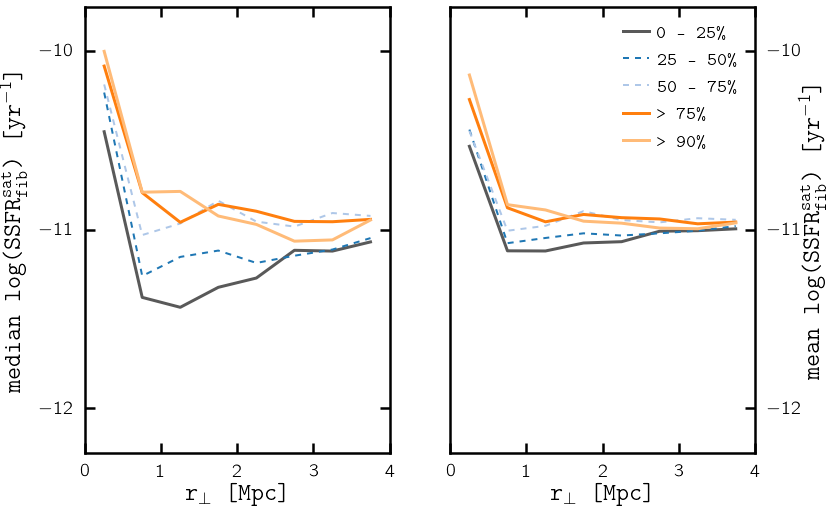

In [12]:
# numpy where of primary galaxies
isprimary = np.where(catalog['primary'] == 1)
primary_ssfr_plot(isprimary, Mmin=10., Mmax=10.5)

Neighboring galaxies of central galaxies in the $>75, 90\%$ percentile show "significantly" enhanced $\mathrm{SSFR_{fib}^{sat}}$ for $r_\perp < 3\;\mathrm{Mpc}$. Significantly is in quotes because there are no error bars. *This will be addressed with jackknife error bars, soon!* Now we ask... 

### How much conformity do we observe -- beyond the central galaxy halo?
As in, how much conformity would we detect if we remove the satellite galaxies in the same group as the central? 


First we check how well the primary galaxies identified using Kauffmann's isolation criteria corresponds to Tinker et al. (2011)'s central galaxies.

In [13]:
p_sat_primary = catalog['p_sat'][isprimary]
print 'Fraction of primaries that are also centrals : ', np.float(len(np.where(p_sat_primary <= 0.5)[0]))/np.float(len(p_sat_primary))


Fraction of primaries that are also centrals :  0.956698584866


The majority galaxies that are identified as **primaries** are also **centrals**. 

Now let us look at the conformity signal of galaxies that are both primaries and centrals.

[-11.44807005 -10.58123207 -10.20741343  -9.98729372]


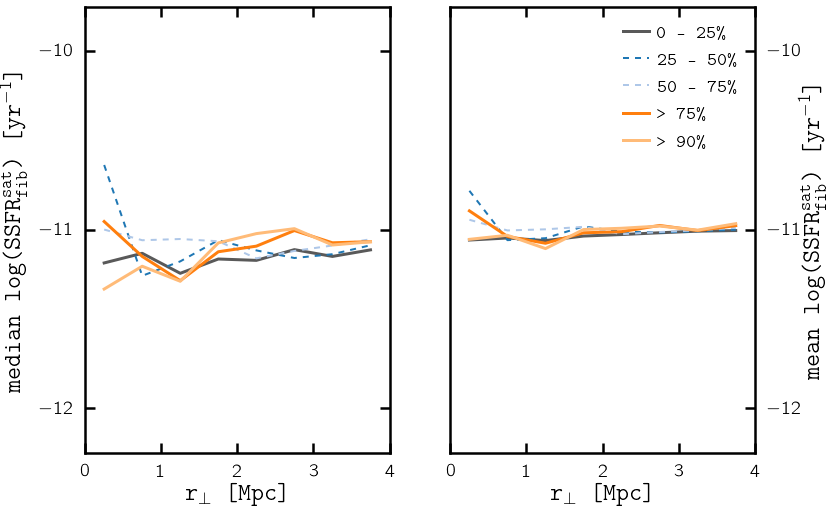

In [14]:
# numpy where of primary galaxies that are ALSO centrals
isboth = np.where((catalog['primary'] == 1) & (catalog['p_sat'] <= 0.5))
primary_ssfr_plot(isboth, Mmin=10., Mmax=10.5)

There is little to no conformity signal...

[-11.44807005 -10.58123207 -10.20741343  -9.98729372]


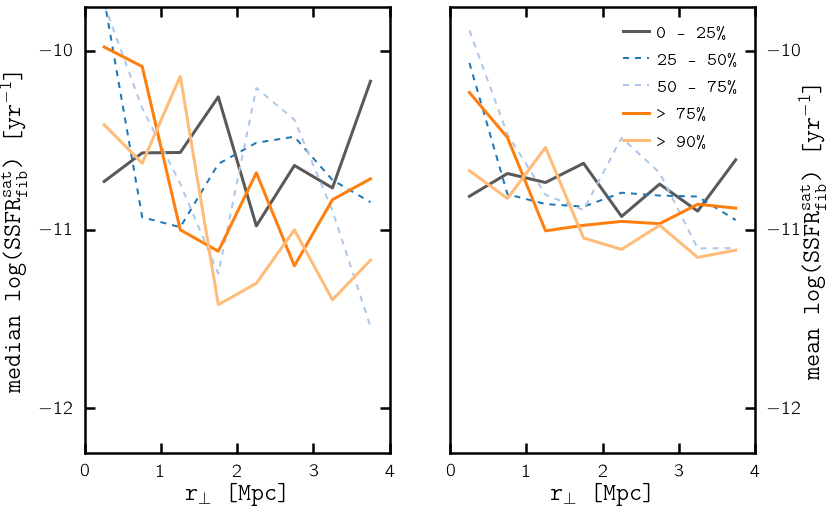

In [15]:
# numpy where of primary galaxies that are NOT centrals
isprimary_notcentral = np.where((catalog['primary'] == 1) & (catalog['p_sat'] > 0.5))
primary_ssfr_plot(isprimary_notcentral, Mmin=10., Mmax=10.5)

In [16]:
def plot_primary_ssfr_neighbor(isprimarycentral, neighbor='central', Mmin=10., Mmax=10.5): 
    
    is_primary = np.where(catalog['primary'] == 1)
    ssfr_primary_mpaj = catalog['ssfr_tot_mpajhu'][is_primary]
    mass_primary_mpaj = catalog['mass_tot_mpajhu'][is_primary]

    primary_cut_mpaj = np.where((mass_primary_mpaj > Mmin) & (mass_primary_mpaj < Mmax))[0]
    ssfr_primary_cutted = ssfr_primary_mpaj[primary_cut_mpaj]
    primary_qs = np.percentile(ssfr_primary_cutted, [25, 50, 75, 90])
    print primary_qs
    
    ssfr_pricen_mpaj = catalog['ssfr_tot_mpajhu'][isprimarycentral]
    mass_pricen_mpaj = catalog['mass_tot_mpajhu'][isprimarycentral]

    # MPA-JHU mass cut
    pricen_cut_mpaj = np.where((mass_pricen_mpaj > Mmin) & (mass_pricen_mpaj < Mmax))[0]
    ssfr_pricen_cutted = ssfr_pricen_mpaj[pricen_cut_mpaj]

    pricen_ssfr_bin_0to25 = np.where(ssfr_pricen_cutted < primary_qs[0])
    pricen_ssfr_bin_25to50 = np.where((ssfr_pricen_cutted >= primary_qs[0]) & (ssfr_pricen_cutted < primary_qs[1]))
    pricen_ssfr_bin_50to75 = np.where((ssfr_pricen_cutted >= primary_qs[1]) & (ssfr_pricen_cutted < primary_qs[2]))
    pricen_ssfr_bin_75plus = np.where(ssfr_pricen_cutted > primary_qs[2])
    pricen_ssfr_bin_90plus = np.where(ssfr_pricen_cutted > primary_qs[3])
    pricen_ssfr_bins = [pricen_ssfr_bin_0to25, pricen_ssfr_bin_25to50, pricen_ssfr_bin_50to75, 
                        pricen_ssfr_bin_75plus, pricen_ssfr_bin_90plus]

    med_pricen_ssfr_rperp = [] 
    mean_pricen_ssfr_rperp = [] 
    for pricen_ssfr_bin in pricen_ssfr_bins: 
        # indices of neighbors that are within the central SSFR & mass bin 
        neigh_inbin = np.concatenate([
                np.array(catalog['neighbor_indices'][i]) for i in pricen_cut_mpaj[pricen_ssfr_bin]
            ]).astype('int')
        neigh_rperp = np.concatenate([
                np.array(catalog['neighbor_rperp'][i]) for i in pricen_cut_mpaj[pricen_ssfr_bin]
            ])
        neigh_ssfr = catalog['ssfr_fib_mpajhu'][neigh_inbin]
        neigh_psat = catalog['p_sat'][neigh_inbin]
        if neighbor == 'central': 
            keep_neigh = np.where(neigh_psat <= 0.5)
        elif neighbor == 'satellite':
            keep_neigh = np.where(neigh_psat > 0.5)
        
        neigh_ssfr = neigh_ssfr[keep_neigh]
        neigh_rperp = neigh_rperp[keep_neigh]
            
        med_ssfr_rperp_bin = np.zeros(len(rperp_bins)-1)
        mean_ssfr_rperp_bin = np.zeros(len(rperp_bins)-1)
        for i_r in range(len(rperp_bins)-1):
            in_rperp_bin = np.where(
                (neigh_rperp > rperp_bins[i_r]) & 
                (neigh_rperp <= rperp_bins[i_r+1]) &
                (np.isnan(neigh_ssfr) == False))
            mean_ssfr_rperp_bin[i_r] = np.mean(neigh_ssfr[in_rperp_bin])
            med_ssfr_rperp_bin[i_r] = np.median(neigh_ssfr[in_rperp_bin])
       
        med_pricen_ssfr_rperp.append(med_ssfr_rperp_bin)
        mean_pricen_ssfr_rperp.append(mean_ssfr_rperp_bin)

    fig = plt.figure(figsize=(12,8))
    sub1 = fig.add_subplot(121)
    sub2 = fig.add_subplot(122)
    for i_cen_ssfr, cen_ssfr in enumerate(med_pricen_ssfr_rperp): 
        if i_cen_ssfr in [1,2]: 
            lwidth = 2
            lstyle = '--'
        else: 
            lwidth = 3
            lstyle = '-'
        sub1.plot(0.5*(rperp_bins[:-1] + rperp_bins[1:]), cen_ssfr, 
                 c=pretty_colors[i_cen_ssfr], lw=lwidth, ls=lstyle)
        sub2.plot(0.5*(rperp_bins[:-1] + rperp_bins[1:]), mean_pricen_ssfr_rperp[i_cen_ssfr], 
                 c=pretty_colors[i_cen_ssfr], lw=lwidth, ls=lstyle, 
                 label=cen_ssfr_bin_labels[i_cen_ssfr])
        
    sub1.set_xlim([0, 4])
    sub1.set_xticks([0, 1, 2, 3, 4])
    sub1.set_xlabel(r'$\mathtt{r}_\perp$ [Mpc]', fontsize=25)
    sub2.set_xlim([0, 4])
    sub2.set_xticks([0, 1, 2, 3, 4])
    sub2.set_xlabel(r'$\mathtt{r}_\perp$ [Mpc]', fontsize=25)

    sub1.set_ylim([-12.25, -9.75])
    sub1.set_yticks([-12., -11., -10.])
    sub1.set_ylabel(r'median log($\mathtt{SSFR_{fib}^{sat}}$) [$\mathtt{yr}^{-1}$]', fontsize=25)
    sub2.yaxis.tick_right()
    sub2.yaxis.set_label_position('right')
    sub2.set_ylim([-12.25, -9.75])
    sub2.set_yticks([-12., -11., -10.])
    sub2.set_ylabel(r'mean log($\mathtt{SSFR_{fib}^{sat}}$) [$\mathtt{yr}^{-1}$]', fontsize=25)

    sub2.legend(handletextpad=0.1)

[-11.44807005 -10.58123207 -10.20741343  -9.98729372]


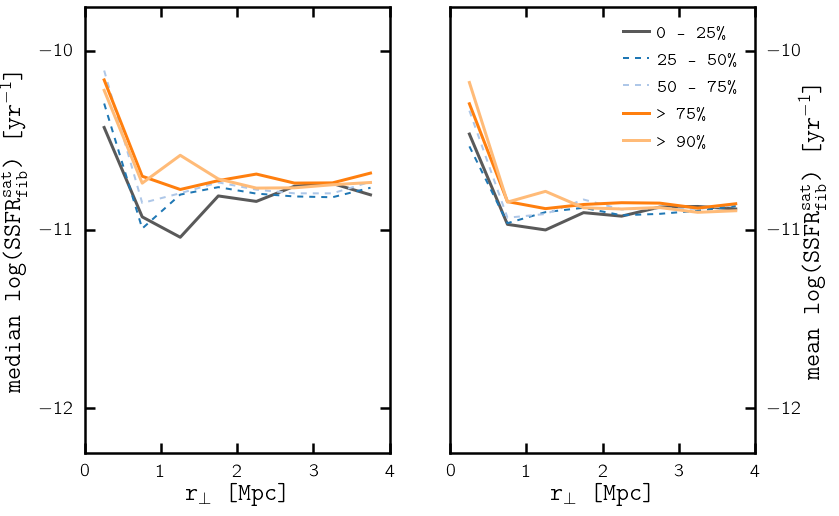

In [18]:
isprimary = np.where(catalog['primary'] == 1)
plot_primary_ssfr_neighbor(isprimary, neighbor='central', Mmin=10., Mmax=10.5)

[-11.44807005 -10.58123207 -10.20741343  -9.98729372]


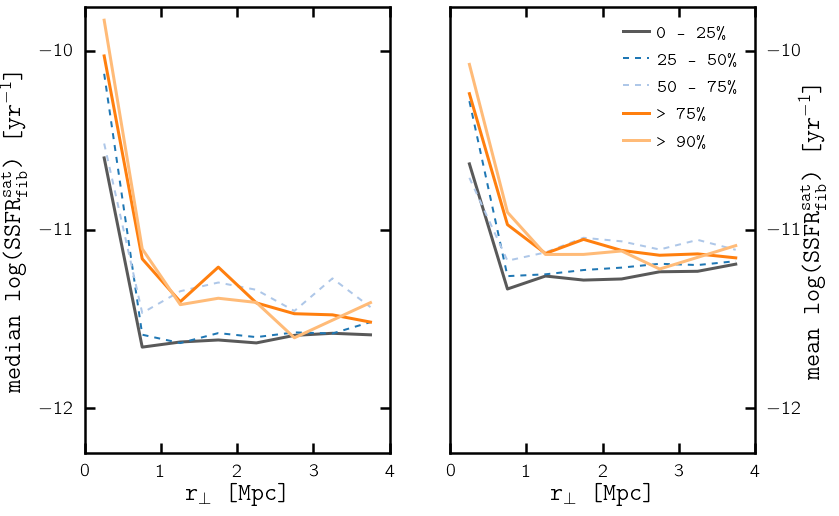

In [19]:
plot_primary_ssfr_neighbor(isprimary, neighbor='satellite', Mmin=10., Mmax=10.5)